In [1]:
# DF-Net Imports
from collections import defaultdict
import cv2
from itertools import islice
from multiprocessing.pool import ThreadPool as Pool
from pathlib import Path
import torch.nn.functional as F
import tqdm

# Imports
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from pytorch_metric_learning import losses, samplers
from random import randint
import shutil
from skimage import io, transform
import time
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data.sampler import Sampler
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

ERROR:root:The testing module requires faiss. You can install the GPU version with the command 'conda install faiss-gpu -c pytorch' 
                        or the CPU version with 'conda install faiss-cpu -c pytorch'. Learn more at https://github.com/facebookresearch/faiss/blob/master/INSTALL.md


In [2]:
from sklearn.manifold import TSNE

def map_features(outputs, labels, out_file):
    # create array of column for each feature output
    feat_cols = ['feature'+str(i) for i in range(outputs.shape[1])]
    # make dataframe of outputs -> labels
    df = pd.DataFrame(outputs, columns=feat_cols)
    df['y'] = labels
    df['labels'] = df['y'].apply(lambda i: str(i))
    # clear outputs and labels
    outputs, labels = None, None
    # creates an array of random indices from size of outputs
    np.random.seed(42)
    rndperm = np.random.permutation(df.shape[0])
    num_examples = 3000
    df_subset = df.loc[rndperm[:num_examples],:].copy()
    data_subset = df_subset[feat_cols].values
    tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
    tsne_results = tsne.fit_transform(data_subset)
    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]
    plt.figure(figsize=(16,10))
    plt.scatter(
        x=df_subset["tsne-2d-one"],
        y=df_subset["tsne-2d-two"],
        c=df_subset["y"],
        s=3
    )
    plt.savefig(out_file, bbox_inches='tight', pad_inches = 0)
    plt.close()

In [3]:
# Configurations
# Device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Num epochs
num_epochs = 25

# Model 
model = models.resnet50()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Batch size
batch_size = 32

# Data set
train_path = '/lab/vislab/DATA/CUB/images/'

mask_path = './samples/places2/mask/'

# Loss function
criterion = losses.TripletMarginLoss(margin=0.1)

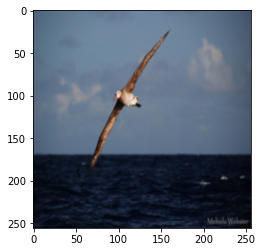

In [4]:
# Dataset

# occlusion transform?
# mask_ = Image.open('/lab/vislab/DATA/masks/mask.jpeg')

transformations = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(train_path, transformations)

plt.imshow(transforms.ToPILImage()(dataset[3][0]), interpolation="bicubic")

train_set, test_set = torch.utils.data.random_split(dataset, [5000, 1033])

train_sampler = torch.utils.data.RandomSampler(train_set)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                   sampler=train_sampler, num_workers=4)

In [5]:
# DF-Net Utils

def resize_like(x, target, mode='bilinear'):
    return F.interpolate(x, target.shape[-2:], mode=mode, align_corners=False)


def list2nparray(lst, dtype=None):
    """fast conversion from nested list to ndarray by pre-allocating space"""
    if isinstance(lst, np.ndarray):
        return lst
    assert isinstance(lst, (list, tuple)), 'bad type: {}'.format(type(lst))
    assert lst, 'attempt to convert empty list to np array'
    if isinstance(lst[0], np.ndarray):
        dim1 = lst[0].shape
        assert all(i.shape == dim1 for i in lst)
        if dtype is None:
            dtype = lst[0].dtype
            assert all(i.dtype == dtype for i in lst), \
                'bad dtype: {} {}'.format(dtype, set(i.dtype for i in lst))
    elif isinstance(lst[0], (int, float, complex, np.number)):
        return np.array(lst, dtype=dtype)
    else:
        dim1 = list2nparray(lst[0])
        if dtype is None:
            dtype = dim1.dtype
        dim1 = dim1.shape
    shape = [len(lst)] + list(dim1)
    rst = np.empty(shape, dtype=dtype)
    for idx, i in enumerate(lst):
        rst[idx] = i
    return rst


def get_img_list(path):
    return sorted(list(Path(path).glob('*.png'))) + \
        sorted(list(Path(path).glob('*.jpg'))) + \
        sorted(list(Path(path).glob('*.jpeg')))

def gen_miss(img, mask, output):
    imgs = get_img_list(img)
    masks = get_img_list(mask)
    print('Total images:', len(imgs), len(masks))

    out = Path(output)
    out.mkdir(parents=True, exist_ok=True)

    for i, (img, mask) in tqdm.tqdm(enumerate(zip(imgs, masks))):
        path = out.joinpath('miss_%04d.png' % (i+1))
        img = cv2.imread(str(img), cv2.IMREAD_COLOR)
        mask = cv2.imread(str(mask), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img.shape[:2][::-1])
        mask = mask[..., np.newaxis]
        miss = img * (mask > 127) + 255 * (mask <= 127)

        cv2.imwrite(str(path), miss)

def merge_imgs(dirs, output, row=1, gap=2, res=512):

    image_list = [get_img_list(path) for path in dirs]
    img_count = [len(image) for image in image_list]
    print('Total images:', img_count) # should be batch size when we walk back into here ... 
    assert min(img_count) > 0, 'Please check the path of empty folder.'

    output_dir = Path(output)
    output_dir.mkdir(parents=True, exist_ok=True)

    n_img = len(dirs)
    row = row
    column = (n_img - 1) // row + 1
    print('Row:', row)
    print('Column:', column)

    for i, unit in tqdm.tqdm(enumerate(zip(*image_list))):
        name = output_dir.joinpath('merge_%04d.png' % i)
        merge = np.ones([
            res*row + (row+1)*gap, res*column + (column+1)*gap, 3], np.uint8) * 255
        for j, img in enumerate(unit):
            r = j // column
            c = j - r * column
            img = cv2.imread(str(img), cv2.IMREAD_COLOR)
            if img.shape[:2] != (res, res):
                img = cv2.resize(img, (res, res))
            start_h, start_w = (r + 1) * gap + r * res, (c + 1) * gap + c * res
            merge[start_h: start_h + res, start_w: start_w + res] = img
        cv2.imwrite(str(name), merge)

In [6]:
# DF-Net Model

def get_norm(name, out_channels):
    if name == 'batch':
        norm = nn.BatchNorm2d(out_channels)
    elif name == 'instance':
        norm = nn.InstanceNorm2d(out_channels)
    else:
        norm = None
    return norm


def get_activation(name):
    if name == 'relu':
        activation = nn.ReLU()
    elif name == 'elu':
        activation == nn.ELU()
    elif name == 'leaky_relu':
        activation = nn.LeakyReLU(negative_slope=0.2)
    elif name == 'tanh':
        activation = nn.Tanh()
    elif name == 'sigmoid':
        activation = nn.Sigmoid()
    else:
        activation = None
    return activation


class Conv2dSame(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()

        padding = self.conv_same_pad(kernel_size, stride)
        if type(padding) is not tuple:
            self.conv = nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding)
        else:
            self.conv = nn.Sequential(
                nn.ConstantPad2d(padding*2, 0),
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, 0)
            )

    def conv_same_pad(self, ksize, stride):
        if (ksize - stride) % 2 == 0:
            return (ksize - stride) // 2
        else:
            left = (ksize - stride) // 2
            right = left + 1
            return left, right

    def forward(self, x):
        return self.conv(x)


class ConvTranspose2dSame(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()

        padding, output_padding = self.deconv_same_pad(kernel_size, stride)
        self.trans_conv = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size, stride,
            padding, output_padding)

    def deconv_same_pad(self, ksize, stride):
        pad = (ksize - stride + 1) // 2
        outpad = 2 * pad + stride - ksize
        return pad, outpad

    def forward(self, x):
        return self.trans_conv(x)


class UpBlock(nn.Module):

    def __init__(self, mode='nearest', scale=2, channel=None, kernel_size=4):
        super().__init__()

        self.mode = mode
        if mode == 'deconv':
            self.up = ConvTranspose2dSame(
                channel, channel, kernel_size, stride=scale)
        else:
            def upsample(x):
                return F.interpolate(x, scale_factor=scale, mode=mode)
            self.up = upsample

    def forward(self, x):
        return self.up(x)


class EncodeBlock(nn.Module):

    def __init__(
            self, in_channels, out_channels, kernel_size, stride,
            normalization=None, activation=None):
        super().__init__()

        self.c_in = in_channels
        self.c_out = out_channels

        layers = []
        layers.append(
            Conv2dSame(self.c_in, self.c_out, kernel_size, stride))
        if normalization:
            layers.append(get_norm(normalization, self.c_out))
        if activation:
            layers.append(get_activation(activation))
        self.encode = nn.Sequential(*layers)

    def forward(self, x):
        return self.encode(x)


class DecodeBlock(nn.Module):

    def __init__(
            self, c_from_up, c_from_down, c_out, mode='nearest',
            kernel_size=4, scale=2, normalization='batch', activation='relu'):
        super().__init__()

        self.c_from_up = c_from_up
        self.c_from_down = c_from_down
        self.c_in = c_from_up + c_from_down
        self.c_out = c_out

        self.up = UpBlock(mode, scale, c_from_up, kernel_size=scale)

        layers = []
        layers.append(
            Conv2dSame(self.c_in, self.c_out, kernel_size, stride=1))
        if normalization:
            layers.append(get_norm(normalization, self.c_out))
        if activation:
            layers.append(get_activation(activation))
        self.decode = nn.Sequential(*layers)

    def forward(self, x, concat=None):
        out = self.up(x)
        if self.c_from_down > 0:
            out = torch.cat([out, concat], dim=1)
        out = self.decode(out)
        return out


class BlendBlock(nn.Module):

    def __init__(
            self, c_in, c_out, ksize_mid=3, norm='batch', act='leaky_relu'):
        super().__init__()
        c_mid = max(c_in // 2, 32)
        self.blend = nn.Sequential(
            Conv2dSame(c_in, c_mid, 1, 1),
            get_norm(norm, c_mid),
            get_activation(act),
            Conv2dSame(c_mid, c_out, ksize_mid, 1),
            get_norm(norm, c_out),
            get_activation(act),
            Conv2dSame(c_out, c_out, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.blend(x)


class FusionBlock(nn.Module):
    def __init__(self, c_feat, c_alpha=1):
        super().__init__()
        c_img = 3
        self.map2img = nn.Sequential(
            Conv2dSame(c_feat, c_img, 1, 1),
            nn.Sigmoid())
        self.blend = BlendBlock(c_img*2, c_alpha)

    def forward(self, img_miss, feat_de):
        img_miss = resize_like(img_miss, feat_de)
        raw = self.map2img(feat_de)
        alpha = self.blend(torch.cat([img_miss, raw], dim=1))
        result = alpha * raw + (1 - alpha) * img_miss
        return result, alpha, raw


class DFNet(nn.Module):
    def __init__(
            self, c_img=3, c_mask=1, c_alpha=3,
            mode='nearest', norm='batch', act_en='relu', act_de='leaky_relu',
            en_ksize=[7, 5, 5, 3, 3, 3, 3, 3], de_ksize=[3]*8,
            blend_layers=[0, 1, 2, 3, 4, 5]):
        super().__init__()

        c_init = c_img + c_mask

        self.n_en = len(en_ksize)
        self.n_de = len(de_ksize)
        assert self.n_en == self.n_de, (
            'The number layer of Encoder and Decoder must be equal.')
        assert self.n_en >= 1, (
            'The number layer of Encoder and Decoder must be greater than 1.')

        assert 0 in blend_layers, 'Layer 0 must be blended.'

        self.en = []
        c_in = c_init
        self.en.append(
            EncodeBlock(c_in, 64, en_ksize[0], 2, None, None))
        for k_en in en_ksize[1:]:
            c_in = self.en[-1].c_out
            c_out = min(c_in*2, 512)
            self.en.append(EncodeBlock(
                c_in, c_out, k_en, stride=2,
                normalization=norm, activation=act_en))

        # register parameters
        for i, en in enumerate(self.en):
            self.__setattr__('en_{}'.format(i), en)

        self.de = []
        self.fuse = []
        for i, k_de in enumerate(de_ksize):

            c_from_up = self.en[-1].c_out if i == 0 else self.de[-1].c_out
            c_out = c_from_down = self.en[-i-1].c_in
            layer_idx = self.n_de - i - 1

            self.de.append(DecodeBlock(
                c_from_up, c_from_down, c_out, mode, k_de, scale=2,
                normalization=norm, activation=act_de))
            if layer_idx in blend_layers:
                self.fuse.append(FusionBlock(c_out, c_alpha))
            else:
                self.fuse.append(None)

        # register parameters
        for i, de in enumerate(self.de[::-1]):
            self.__setattr__('de_{}'.format(i), de)
        for i, fuse in enumerate(self.fuse[::-1]):
            if fuse:
                self.__setattr__('fuse_{}'.format(i), fuse)

    def forward(self, img_miss, mask):

        out = torch.cat([img_miss, mask], dim=1)

        out_en = [out]
        for encode in self.en:
            out = encode(out)
            out_en.append(out)

        results = []
        alphas = []
        raws = []
        for i, (decode, fuse) in enumerate(zip(self.de, self.fuse)):
            out = decode(out, out_en[-i-2])
            if fuse:
                result, alpha, raw = fuse(img_miss, out)
                results.append(result)
                alphas.append(alpha)
                raws.append(raw)

        return results[::-1], alphas[::-1], raws[::-1]

In [7]:
# Inpainter 

class Inpainter:

    def __init__(self, model_path, input_size, batch_size):
        self.model_path = model_path
        self._input_size = input_size
        self.batch_size = batch_size
        self.init_model(model_path)

    @property
    def input_size(self):
        if self._input_size > 0:
            return (self._input_size, self._input_size)
        elif 'celeba' in self.model_path:
            return (256, 256)
        else:
            return (256, 256)

    def init_model(self, path):
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
            print('Using gpu.')
        else:
            self.device = torch.device('cpu')
            print('Using cpu.')

        self.model = DFNet().to(self.device)
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint)
        self.model.eval()

        print('Model %s loaded.' % path)

    def get_name(self, path):
        return '.'.join(path.name.split('.')[:-1])

    def results_path(self, output, img_path, mask_path, prefix='result'):
        img_name = self.get_name(img_path)
        mask_name = self.get_name(mask_path)
        return {
            'result_path': self.sub_dir('result').joinpath(
                'result-{}-{}.png'.format(img_name, mask_name)),
            'raw_path': self.sub_dir('raw').joinpath(
                'raw-{}-{}.png'.format(img_name, mask_name)),
            'alpha_path': self.sub_dir('alpha').joinpath(
                'alpha-{}-{}.png'.format(img_name, mask_name))
        }

    def inpaint_instance(self, img, mask):
        """Assume color image with 3 dimension. CWH"""
        img = img.view(1, *img.shape)
        mask = mask.view(1, 1, *mask.shape)
        return self.inpaint_batch(img, mask).squeeze()

    def inpaint_batch(self, imgs, masks):
        """Assume color channel is BGR and input is NWHC np.uint8."""
        imgs = np.transpose(imgs, [0, 3, 1, 2])
        masks = np.transpose(masks, [0, 3, 1, 2])

        imgs = torch.from_numpy(imgs).to(self.device)
        masks = torch.from_numpy(masks).to(self.device)
        imgs = imgs.float().div(255)
        masks = masks.float().div(255)
        imgs_miss = imgs * masks
        results = self.model(imgs_miss, masks)
        if type(results) is list:
            results = results[0]
        results = results.mul(255).byte().data.cpu().numpy()
        results = np.transpose(results, [0, 2, 3, 1])
        return results

    def _process_file(self, output, img_path, mask_path):
        item = {
            'img_path': img_path,
            'mask_path': mask_path,
        }
        item.update(self.results_path(output, img_path, mask_path))
        self.path_pair.append(item)

    def process_single_file(self, output, img_path, mask_path):
        self.path_pair = []
        self._process_file(output, img_path, mask_path)

    def process_dir(self, output, img_dir, mask_dir):
        img_dir = Path(img_dir)
        mask_dir = Path(mask_dir)
        imgs_path = sorted(
            list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png')))
        masks_path = sorted(
            list(mask_dir.glob('*.jpg')) + list(mask_dir.glob('*.png')))

        n_img = len(imgs_path)
        n_mask = len(masks_path)
        n_pair = min(n_img, n_mask)

        self.path_pair = []
        for i in range(n_pair):
            img_path = imgs_path[i % n_img]
            mask_path = masks_path[i % n_mask]
            self._process_file(output, img_path, mask_path)

    def get_process(self, input_size):
        def process(pair):
            img = cv2.imread(str(pair['img_path']), cv2.IMREAD_COLOR)
            mask = cv2.imread(str(pair['mask_path']), cv2.IMREAD_GRAYSCALE)
            if input_size:
#                 img = img[0:256, 0:256]
#                 mask = mask[0:64, 0:64] ## ALSO HERE
                img = cv2.resize(img, input_size)
                mask = cv2.resize(mask, input_size)
            img = np.ascontiguousarray(img.transpose(2, 0, 1)).astype(np.uint8)
            mask = np.ascontiguousarray(
                np.expand_dims(mask, 0)).astype(np.uint8)

            pair['img'] = img
            pair['mask'] = mask
            return pair
        return process

    def _file_batch(self):
        pool = Pool()

        n_pair = len(self.path_pair)
        n_batch = (n_pair-1) // self.batch_size + 1
        
##        n_batch = 4
        
        for i in tqdm.trange(n_batch, leave=False):            
            _buffer = defaultdict(list)
            print(_buffer)
            start = i * self.batch_size
            stop = start + self.batch_size
            process = self.get_process(self.input_size)
            batch = pool.imap_unordered(
                process, islice(self.path_pair, start, stop))
            # so we aren't going through here, EDIT now we are  
            
            for instance in batch:
                for k, v in instance.items():
                    _buffer[k].append(v)
            yield _buffer

    def batch_generator(self):
        generator = self._file_batch
        
        for _buffer in generator():
            for key in _buffer:
                
                
                if key in ['img', 'mask']:
                    _buffer[key] = list2nparray(_buffer[key])
            yield _buffer

    def to_numpy(self, tensor):
        tensor = tensor.mul(255).byte().data.cpu().numpy()
        tensor = np.transpose(tensor, [0, 2, 3, 1])
        return tensor

    def process_batch(self, batch, output, results):
        imgs = torch.from_numpy(batch['img']).to(self.device)
        masks = torch.from_numpy(batch['mask']).to(self.device)
        imgs = imgs.float().div(255)
        masks = masks.float().div(255)
        imgs_miss = imgs * masks

        result, alpha, raw = self.model(imgs_miss, masks)
        result, alpha, raw = result[0], alpha[0], raw[0]
        result = imgs * masks + result * (1 - masks)
        
        result = self.to_numpy(result)
        
#         results.append(result)
        results = np.append(results, result, axis=0)

    
        alpha = self.to_numpy(alpha)
        raw = self.to_numpy(raw)
            
        for i in range(result.shape[0]):
            cv2.imwrite(str(batch['result_path'][i]), result[i])
            cv2.imwrite(str(batch['raw_path'][i]), raw[i])
            cv2.imwrite(str(batch['alpha_path'][i]), alpha[i])
                    
    @property
    def root(self):
        return Path(self.output)

    def sub_dir(self, sub):
        return self.root.joinpath(sub)

    def prepare_folders(self, folders):
        for folder in folders:
            Path(folder).mkdir(parents=True, exist_ok=True)

    def inpaint(self, output, img, mask, merge_result=False):

        self.output = output
        self.prepare_folders([
            self.sub_dir('result'), self.sub_dir('alpha'),
            self.sub_dir('raw')])

        if os.path.isfile(img) and os.path.isfile(mask):
            if img.endswith(('.png', '.jpg', '.jpeg')):
                self.process_single_file(output, img, mask)
                _type = 'file'
            else:
                raise NotImplementedError()
        elif os.path.isdir(img) and os.path.isdir(mask):
            self.process_dir(output, img, mask)
            _type = 'dir'
        else:
            print('Img: ', img)
            print('Mask: ', mask)
            raise NotImplementedError(
                'img and mask should be both file or directory.')

        print('# Inpainting...')
        print('Input size:', self.input_size)
        results = np.empty((32,256,256,3), int) # it's just following this dimension? # are we getting the error here?
#         results = []
        for batch in self.batch_generator():
            self.process_batch(batch, output, results)
        print('Inpainting finished.')
        ## so results should contain everything now 

        if merge_result and _type == 'dir':
            miss = self.sub_dir('miss')
            merge = self.sub_dir('merge')

            print('# Preparing input images...')
            gen_miss(img, mask, miss) # dfnet util fn
            print('# Merging...')
            merge_imgs([
                miss, self.sub_dir('raw'), self.sub_dir('alpha'),
                self.sub_dir('result'), img], merge, res=self.input_size[0])
            print('Merging finished.')
            
            
        
        results = np.transpose(results, [0, 3, 1, 2])

        return results

In [8]:
# Main Trainer
def train_model():
    """Generic function to train model"""

    start_time = datetime.now()
    correct = 0 
    incorrect = 0 
    num_batches = 1
    loss_values = []

    # DF-Net Tester Instantiate
    pretrained_model_path = './model/model_places2.pth'
    inpainter = Inpainter(pretrained_model_path, 256, 1) # was 8, should it be 1 or 32?

    # Epochs 
    for epoch in range(num_epochs): 
        print("epoch num:", epoch)
        
        running_outputs = torch.FloatTensor().cpu()
        running_labels = torch.LongTensor().cpu()
        running_loss = 0.0
        model.train()
                                
        # Batches
        for batch_idx, (inputs, labels) in enumerate(train_loader): 
            
            img_path = './samples/places2/img/'
            os.makedirs(img_path)
            
            print("inputs[8].shape: ", inputs[8].shape)
            
            for img_idx in range(batch_size-1):
                
                img = inputs[img_idx] # or is it running out here
                
                img_idx_name = ''
                # so that should be 0-9
                if img_idx < 10:
                    img_idx_name = '0%d' % img_idx
                else: 
                    img_idx_name = '%d' % img_idx

                save_image(img, './samples/places2/img/img_{}.png'.format(img_idx_name))
            
            inpainted_img_batch = inpainter.inpaint('output/places2/', img_path, mask_path, merge_result=True)
            inpainted_img_batch = torch.from_numpy(inpainted_img_batch)
#             print(type(inpainted_img_batch[0]))
#             print(inpainted_img_batch[0])
            
            # delete img_path
            shutil.rmtree(img_path)
                            
            optimizer.zero_grad()
            inpainted_img_batch, labels = inpainted_img_batch.to(device, dtype=torch.float), labels.to(device)
            output = model.forward(inpainted_img_batch)
            
            running_outputs = torch.cat((running_outputs, output.cpu().detach()), 0)
            running_labels = torch.cat((running_labels, labels.cpu().detach()), 0)
            
#             print("inpainted_img_batch.shape",inpainted_img_batch.shape)
#             print("labels.shape",labels.shape)
            
            loss = criterion(output, labels)
            loss = Variable(loss, requires_grad = True)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_outputs = torch.cat((running_outputs, output.cpu().detach()), 0)
            running_labels = torch.cat((running_labels, labels.cpu().detach()), 0)
            num_batches += 1
            
        # Accuracy
        for idx, emb in enumerate(running_outputs.to(device)):    
            pairwise = torch.nn.PairwiseDistance(p=2).to(device)[1]
            dist = pairwise(emb, running_outputs.to(device))
            closest = torch.topk(dist, 2, largest=False).indices[1]
            if running_labels[idx] == running_labels[closest]:
                correct += 1
            else:
                incorrect += 1

        print(running_loss / num_batches)
        print("Correct", correct)
        print("Incorrect", incorrect)

        # t-SNE
        map_features(running_outputs, running_labels, "outfile")
        # Loss Plot            
        loss_values.append(running_loss / num_batches)

        time_elapsed = datetime.now() - start_time 
        print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))    

    plt.plot(loss_values)    
    return model, running_loss

In [ ]:
# Run Script
model.to(device)

# perhaps parameterize the train model to take in our pre-processed data

trained_model, loss = train_model()
print(loss)

Using gpu.
Model ./model/model_places2.pth loaded.
epoch num: 0
inputs[8].shape:  torch.Size([3, 256, 256])


  3%|▎         | 1/31 [00:00<00:05,  5.48it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 10%|▉         | 3/31 [00:00<00:04,  6.40it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 23%|██▎       | 7/31 [00:00<00:03,  6.99it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 29%|██▉       | 9/31 [00:01<00:03,  6.66it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 35%|███▌      | 11/31 [00:01<00:02,  7.56it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 48%|████▊     | 15/31 [00:01<00:01,  9.12it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 55%|█████▍    | 17/31 [00:01<00:01,  9.66it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 68%|██████▊   | 21/31 [00:02<00:00, 10.52it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 74%|███████▍  | 23/31 [00:02<00:00, 10.76it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 87%|████████▋ | 27/31 [00:02<00:00, 10.59it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 94%|█████████▎| 29/31 [00:03<00:00, 10.79it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


5it [00:00, 45.13it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 49.03it/s]
2it [00:00, 17.97it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 17.55it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 13.49it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 13.31it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 13.69it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:00<00:01, 14.57it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:00, 15.03it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:00, 15.55it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 15.11it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:01<00:00, 13.30it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:01<00:00, 14.09it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 59.57it/s]                         

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 55.15it/s]
2it [00:00, 19.55it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.43it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  0%|          | 0/31 [00:00<?, ?it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


  6%|▋         | 2/31 [00:00<00:03,  8.41it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 16%|█▌        | 5/31 [00:00<00:02,  8.71it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 23%|██▎       | 7/31 [00:00<00:02,  9.51it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 35%|███▌      | 11/31 [00:01<00:01, 10.50it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 42%|████▏     | 13/31 [00:01<00:01, 11.40it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 55%|█████▍    | 17/31 [00:01<00:01, 12.72it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 68%|██████▊   | 21/31 [00:01<00:00, 14.20it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 81%|████████  | 25/31 [00:02<00:00, 14.67it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 94%|█████████▎| 29/31 [00:02<00:00, 15.07it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


7it [00:00, 61.32it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 52.56it/s]
2it [00:00, 18.19it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.05it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:01, 15.20it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:01, 14.91it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 14.83it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 14.24it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:00<00:01, 12.26it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 11.04it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:01, 10.66it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 11.08it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:01<00:00, 12.56it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 13.78it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 52.66it/s]
2it [00:00, 18.00it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 17.88it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:01, 14.84it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:01, 14.45it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 14.59it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:00<00:01, 14.27it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:00<00:01, 14.35it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:00, 14.72it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 14.65it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:01<00:00, 13.89it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:01<00:00, 13.71it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 97%|█████████▋| 30/31 [00:02<00:00, 13.56it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


3it [00:00, 16.30it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 40.67it/s]
2it [00:00, 17.52it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.42it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 11.95it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 11.47it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:02, 11.23it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 11.21it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 11.33it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 11.65it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 11.62it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 11.92it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 13.13it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 13.06it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


5it [00:00, 44.42it/s]                         

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 51.63it/s]
2it [00:00, 19.52it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 21.52it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 14.18it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:01, 13.96it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 13.98it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:00<00:01, 14.65it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:00<00:01, 14.62it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:00, 14.36it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 13.42it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:01<00:00, 13.05it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:01<00:00, 12.61it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 97%|█████████▋| 30/31 [00:02<00:00, 11.72it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 54.09it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 51.41it/s]
2it [00:00, 18.11it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 18.15it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 13.12it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:01, 13.60it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 13.96it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 14.24it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 10.04it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 10.40it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:01, 10.58it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 10.80it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 11.23it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 11.29it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 46.36it/s]
2it [00:00, 18.48it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.49it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 11.71it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 11.71it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 11.80it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 11.79it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 11.72it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 11.60it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 12.15it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 12.15it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 11.68it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 11.70it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


5it [00:00, 49.25it/s]                         

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 53.99it/s]
2it [00:00, 18.09it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.49it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:01, 16.23it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 19%|█▉        | 6/31 [00:00<00:01, 15.81it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 14.73it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:00<00:01, 14.85it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 14.82it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 14.19it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:01<00:00, 14.64it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:01<00:00, 12.95it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 97%|█████████▋| 30/31 [00:02<00:00, 11.27it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 55.41it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 53.24it/s]
0it [00:00, ?it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.94it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 12.85it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 13.23it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 14.10it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:00<00:01, 14.10it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:00<00:01, 14.15it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:00, 14.24it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 14.29it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 13.81it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:01<00:00, 12.22it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 12.28it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 56.50it/s]                         

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 49.50it/s]
2it [00:00, 17.79it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.28it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 12.50it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 16%|█▌        | 5/31 [00:00<00:03,  8.51it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 23%|██▎       | 7/31 [00:00<00:02,  9.28it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:01<00:02,  9.33it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:01<00:01,  9.94it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 10.59it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:01, 10.99it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:02<00:00, 11.13it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:02<00:00, 11.33it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00,  9.29it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 97%|█████████▋| 30/31 [00:02<00:00, 10.57it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 53.07it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 51.40it/s]
2it [00:00, 18.73it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.73it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:01, 15.54it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:01, 15.25it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 14.26it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:01<00:01,  9.87it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 10.28it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:01, 10.97it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 11.25it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:02<00:00, 12.25it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 12.71it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 97%|█████████▋| 30/31 [00:02<00:00, 13.35it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


7it [00:00, 62.07it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 57.49it/s]
3it [00:00, 20.91it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 21.13it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 14.06it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:01, 13.55it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 12.88it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 12.68it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 12.00it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 11.66it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 11.35it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 11.04it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 10.90it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 10.87it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 49.38it/s]
2it [00:00, 19.43it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.34it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 12.90it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 19%|█▉        | 6/31 [00:00<00:01, 13.95it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 13.75it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:00<00:01, 13.01it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 12.51it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:01, 12.09it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 11.82it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:01<00:00, 11.50it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 11.42it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 97%|█████████▋| 30/31 [00:02<00:00, 11.44it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 53.31it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 51.46it/s]
2it [00:00, 18.00it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.09it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 13.47it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 13.23it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 13.51it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 13.67it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 13.21it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 12.61it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 11.57it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 10.82it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 11.17it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 11.37it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 35.47it/s]
2it [00:00, 18.26it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 18.50it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 12.50it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 12.39it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 11.91it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 11.67it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 12.12it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 12.26it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 11.84it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 11.62it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 11.33it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 11.26it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 51.38it/s]
2it [00:00, 19.22it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 16.31it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 13.04it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 13.16it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 12.24it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 35%|███▌      | 11/31 [00:00<00:01, 11.20it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 42%|████▏     | 13/31 [00:01<00:01, 11.29it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 55%|█████▍    | 17/31 [00:01<00:01, 11.24it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 61%|██████▏   | 19/31 [00:01<00:01,  9.89it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 68%|██████▊   | 21/31 [00:01<00:01,  9.84it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 74%|███████▍  | 23/31 [00:02<00:00, 10.08it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 87%|████████▋ | 27/31 [00:02<00:00, 10.52it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 94%|█████████▎| 29/31 [00:02<00:00, 10.59it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 52.61it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 46.73it/s]
2it [00:00, 16.41it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 17.74it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 13.73it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 13.43it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 13.00it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 13.08it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 13.20it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 12.84it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 13.46it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 12.73it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:01<00:00, 12.95it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 13.10it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


5it [00:00, 47.06it/s]                         

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 44.26it/s]
2it [00:00, 15.86it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 15.71it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 11.39it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 16%|█▌        | 5/31 [00:00<00:02, 10.80it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 23%|██▎       | 7/31 [00:00<00:02, 10.82it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 35%|███▌      | 11/31 [00:01<00:01, 10.98it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 42%|████▏     | 13/31 [00:01<00:01, 10.66it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 55%|█████▍    | 17/31 [00:01<00:01, 11.03it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 61%|██████▏   | 19/31 [00:01<00:01, 10.49it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 68%|██████▊   | 21/31 [00:01<00:00, 10.73it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 81%|████████  | 25/31 [00:02<00:00, 10.86it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 87%|████████▋ | 27/31 [00:02<00:00, 10.93it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 48.41it/s]
2it [00:00, 16.58it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 15.57it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 11.17it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 11.30it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:02, 11.29it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 11.20it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 10.88it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 10.86it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 11.06it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:02<00:00, 10.79it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 10.71it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 10.68it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 43.19it/s]
2it [00:00, 18.08it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.09it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  0%|          | 0/31 [00:00<?, ?it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 10.66it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 19%|█▉        | 6/31 [00:00<00:02, 10.88it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:02, 10.94it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:01<00:01, 10.90it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 10.96it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:01, 11.14it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 11.12it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:02<00:00, 11.36it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 11.41it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 97%|█████████▋| 30/31 [00:02<00:00, 11.33it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


5it [00:00, 47.18it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 48.59it/s]
2it [00:00, 18.02it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 18.69it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 13.25it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 12.48it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 12.09it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 11.59it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 11.53it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 11.68it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 11.64it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:02<00:00, 11.47it/s]

defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00,  8.29it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 97%|█████████▋| 30/31 [00:02<00:00,  9.54it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 52.69it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 52.58it/s]
2it [00:00, 16.56it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.09it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 14.01it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 19%|█▉        | 6/31 [00:00<00:01, 14.65it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 13.82it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:00<00:01, 14.50it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 14.38it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 14.72it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 14.23it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:01<00:00, 13.68it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 97%|█████████▋| 30/31 [00:02<00:00, 14.18it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


7it [00:00, 62.28it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 54.71it/s]
2it [00:00, 19.36it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 17.68it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 11.96it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 12.01it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 12.18it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 11.60it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 12.11it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01,  7.82it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:01,  9.07it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:01, 10.30it/s]

defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:02<00:01,  8.78it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 10.54it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 10.83it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 53.89it/s]
2it [00:00, 18.75it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 20.51it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 13.27it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 13.38it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 12.97it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 12.67it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 12.23it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 12.42it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 12.43it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 12.51it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 12.78it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 12.90it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


4it [00:00, 36.78it/s]                         

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 48.46it/s]
2it [00:00, 18.57it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.67it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 14.18it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:01, 13.94it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 12.53it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 12.15it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 11.80it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 11.87it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:01, 11.91it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 11.25it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:02<00:00, 11.13it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 10.91it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 50.13it/s]
2it [00:00, 18.60it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.04it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  0%|          | 0/31 [00:00<?, ?it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 10%|▉         | 3/31 [00:00<00:04,  6.43it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 23%|██▎       | 7/31 [00:00<00:02,  8.22it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 29%|██▉       | 9/31 [00:00<00:02,  8.93it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:01<00:01,  9.61it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 10.24it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:01, 10.45it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:02<00:00, 10.66it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:02<00:00, 10.80it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 10.99it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 97%|█████████▋| 30/31 [00:02<00:00, 10.96it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


5it [00:00, 48.74it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 47.96it/s]
2it [00:00, 17.81it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 16.44it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 10.93it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 11.10it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 23%|██▎       | 7/31 [00:00<00:02, 10.69it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 35%|███▌      | 11/31 [00:00<00:01, 11.24it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 42%|████▏     | 13/31 [00:01<00:01, 11.36it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 55%|█████▍    | 17/31 [00:01<00:01, 10.98it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 61%|██████▏   | 19/31 [00:01<00:01, 10.64it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 74%|███████▍  | 23/31 [00:02<00:00, 10.80it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 81%|████████  | 25/31 [00:02<00:00, 10.46it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 94%|█████████▎| 29/31 [00:02<00:00, 10.90it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 38.21it/s]
2it [00:00, 16.97it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.27it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 12.41it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 19%|█▉        | 6/31 [00:00<00:01, 13.40it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 14.08it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:00<00:01, 13.90it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 13.06it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:00, 13.46it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 12.96it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:01<00:00, 11.01it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 11.34it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 97%|█████████▋| 30/31 [00:02<00:00, 11.19it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 52.40it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 55.28it/s]
2it [00:00, 19.45it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.49it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 12.90it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 12.90it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 12.32it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 12.09it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 11.85it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 11.42it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 11.35it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 11.23it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 11.19it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 11.13it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 57.69it/s]                         

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 52.85it/s]
3it [00:00, 20.43it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.80it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 12.96it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 16%|█▌        | 5/31 [00:00<00:02, 11.76it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 23%|██▎       | 7/31 [00:00<00:02, 11.75it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 35%|███▌      | 11/31 [00:00<00:01, 11.40it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 42%|████▏     | 13/31 [00:01<00:01, 11.25it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 55%|█████▍    | 17/31 [00:01<00:01, 11.26it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 61%|██████▏   | 19/31 [00:01<00:01, 11.61it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 74%|███████▍  | 23/31 [00:02<00:00, 11.57it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 81%|████████  | 25/31 [00:02<00:00, 11.05it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 94%|█████████▎| 29/31 [00:02<00:00, 11.09it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 54.70it/s]
0it [00:00, ?it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.84it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  0%|          | 0/31 [00:00<?, ?it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 11.11it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 12.87it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 13.39it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 13.47it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 13.54it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 14.24it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:01<00:00, 14.34it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:01<00:00, 14.76it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 97%|█████████▋| 30/31 [00:02<00:00, 13.72it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 48.25it/s]
3it [00:00, 22.12it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 21.60it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 14.12it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:01, 13.85it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 13.28it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 13.42it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 13.06it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 13.30it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 13.30it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 12.89it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:01<00:00, 13.02it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 13.41it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 39.01it/s]
2it [00:00, 19.32it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 20.36it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 12.75it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 13.10it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 13.13it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 11.29it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 12.45it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 12.24it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 12.77it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 12.88it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 12.89it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 13.26it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 57.49it/s]                         

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 45.66it/s]
2it [00:00, 18.37it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 18.39it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 11.04it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 11.49it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 23%|██▎       | 7/31 [00:00<00:02, 11.22it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:02, 10.38it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:01<00:01, 10.52it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 11.53it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:01, 12.06it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 12.69it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:01<00:00, 13.06it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 13.16it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 51.04it/s]
2it [00:00, 18.02it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.44it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 13.00it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 13.26it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 12.90it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 12.70it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 13.19it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 13.50it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 13.15it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 13.15it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:01<00:00, 12.76it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 12.49it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


5it [00:00, 47.98it/s]                         

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 46.49it/s]
3it [00:00, 20.48it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 20.01it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 11.77it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 12.27it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 12.71it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 12.38it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 11.68it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 11.60it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 13.43it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:01<00:00, 14.01it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00,  9.93it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 52.82it/s]
2it [00:00, 18.94it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 20.21it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:01, 14.97it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:01, 14.02it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 14.42it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:00<00:01, 13.83it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 13.74it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:00, 13.21it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 13.41it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:01<00:00, 13.44it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:01<00:00, 13.66it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 97%|█████████▋| 30/31 [00:02<00:00, 13.40it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 49.38it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 50.54it/s]
2it [00:00, 19.72it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 20.59it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 14.06it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 19%|█▉        | 6/31 [00:00<00:02, 10.74it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:02, 10.49it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 11.09it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 11.92it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 12.28it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 12.74it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 13.05it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:02<00:00, 13.06it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 10.49it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 97%|█████████▋| 30/31 [00:02<00:00, 10.50it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 55.86it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 33.00it/s]
2it [00:00, 19.35it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 20.45it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 13.37it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 13.48it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 23%|██▎       | 7/31 [00:00<00:02,  8.28it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 29%|██▉       | 9/31 [00:00<00:02,  9.37it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 42%|████▏     | 13/31 [00:01<00:01, 11.11it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 48%|████▊     | 15/31 [00:01<00:01, 11.81it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 61%|██████▏   | 19/31 [00:01<00:00, 12.72it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 68%|██████▊   | 21/31 [00:01<00:00, 12.54it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 81%|████████  | 25/31 [00:02<00:00, 12.56it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 87%|████████▋ | 27/31 [00:02<00:00, 12.85it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 52.60it/s]
2it [00:00, 17.59it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 20.11it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  0%|          | 0/31 [00:00<?, ?it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


  6%|▋         | 2/31 [00:00<00:03,  9.39it/s]

defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:05,  5.28it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 19%|█▉        | 6/31 [00:00<00:03,  6.54it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:01<00:02,  7.24it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:01<00:02,  8.55it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 10.93it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:02<00:00, 12.72it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:02<00:00, 13.37it/s]

defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00,  9.92it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 10.63it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 56.25it/s]                         

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 43.11it/s]
2it [00:00, 19.58it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.68it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:01, 14.73it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 19%|█▉        | 6/31 [00:00<00:01, 14.83it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 14.98it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:00<00:01, 14.56it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:00<00:01, 14.72it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 14.65it/s]

defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:01, 10.09it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 12.02it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:01<00:00, 12.72it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 13.81it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 56.86it/s]                         

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 50.35it/s]
2it [00:00, 19.94it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.89it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 13.23it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 12.44it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 13.16it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 13.84it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 13.80it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 13.80it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 13.48it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 12.98it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 12.10it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 12.42it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 55.75it/s]
3it [00:00, 20.74it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.70it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 13.10it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 13.19it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 19%|█▉        | 6/31 [00:00<00:01, 13.43it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 12.13it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:00<00:01, 12.59it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 13.15it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:00, 13.19it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 13.37it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:01<00:00, 13.38it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 13.36it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 40.25it/s]
2it [00:00, 19.57it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 20.59it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 13.63it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 19%|█▉        | 6/31 [00:00<00:01, 14.43it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 14.29it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:00<00:01, 14.72it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 14.93it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:00, 14.10it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 13.65it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:01<00:00, 13.33it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 13.14it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 36.72it/s]
2it [00:00, 19.79it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.58it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 10.92it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 11.51it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 12.37it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 12.52it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 12.64it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 12.80it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 13.10it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 12.99it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 12.94it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 12.82it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 55.65it/s]                         

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 49.93it/s]
2it [00:00, 19.20it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 20.04it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 11.91it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 16%|█▌        | 5/31 [00:00<00:02, 11.46it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 23%|██▎       | 7/31 [00:00<00:02, 11.89it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 35%|███▌      | 11/31 [00:00<00:01, 12.18it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 42%|████▏     | 13/31 [00:01<00:01, 12.14it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 55%|█████▍    | 17/31 [00:01<00:01, 12.70it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 61%|██████▏   | 19/31 [00:01<00:01, 11.14it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 68%|██████▊   | 21/31 [00:01<00:00, 11.79it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 81%|████████  | 25/31 [00:02<00:00, 11.64it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 87%|████████▋ | 27/31 [00:02<00:00, 11.12it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


0it [00:00, ?it/s]                             

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 57.97it/s]
3it [00:00, 26.65it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 22.84it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 13.95it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 11.53it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 19%|█▉        | 6/31 [00:00<00:02, 11.66it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 12.58it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:00<00:01, 12.95it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 12.37it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:01, 12.38it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 12.02it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:01<00:00, 12.11it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 12.55it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 97%|█████████▋| 30/31 [00:02<00:00, 11.87it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 52.25it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 50.24it/s]
2it [00:00, 19.41it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.12it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 14.10it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:01, 13.54it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 13.91it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 39%|███▊      | 12/31 [00:00<00:01, 14.18it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 14.02it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:00, 14.19it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 13.99it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:01<00:00, 14.34it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:01<00:00, 14.44it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


5it [00:00, 49.96it/s]                         

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 57.05it/s]
2it [00:00, 19.76it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 18.73it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:01, 13.63it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 13.48it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 13.37it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 13.41it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 12.63it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 12.14it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 12.01it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 12.70it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 12.70it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 55.36it/s]                         

defaultdict(<class 'list'>, {})
Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 53.51it/s]
2it [00:00, 17.79it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.55it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:01, 15.13it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 13.27it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 13.73it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 13.35it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 13.89it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 58%|█████▊    | 18/31 [00:01<00:00, 14.62it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 14.95it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 77%|███████▋  | 24/31 [00:01<00:00, 14.77it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:01<00:00, 12.35it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 97%|█████████▋| 30/31 [00:02<00:00, 11.76it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


6it [00:00, 57.40it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 58.35it/s]
2it [00:00, 19.26it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 19.27it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 13.14it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:02, 12.96it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 12.86it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 13.20it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 13.28it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 12.98it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 12.62it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 12.58it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 84%|████████▍ | 26/31 [00:02<00:00, 12.63it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 90%|█████████ | 28/31 [00:02<00:00, 12.65it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 97%|█████████▋| 30/31 [00:02<00:00, 12.63it/s]

defaultdict(<class 'list'>, {})


6it [00:00, 53.68it/s]                         

Inpainting finished.
# Preparing input images...
Total images: 31 32


31it [00:00, 54.51it/s]
3it [00:00, 21.63it/s]

# Merging...
Total images: [32, 62, 62, 62, 31]
Row: 1
Column: 5


31it [00:01, 22.86it/s]


Merging finished.
inputs[8].shape:  torch.Size([3, 256, 256])


  6%|▋         | 2/31 [00:00<00:02, 13.93it/s]

# Inpainting...
Input size: (256, 256)
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 13%|█▎        | 4/31 [00:00<00:01, 14.04it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 26%|██▌       | 8/31 [00:00<00:01, 13.04it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 32%|███▏      | 10/31 [00:00<00:01, 13.33it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 45%|████▌     | 14/31 [00:01<00:01, 12.49it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 52%|█████▏    | 16/31 [00:01<00:01, 12.79it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 65%|██████▍   | 20/31 [00:01<00:00, 12.57it/s]

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


 71%|███████   | 22/31 [00:01<00:00, 12.49it/s]

In [174]:
# RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64 3 7 7,
# but got 5-dimensional input of size [4, 8, 256, 256, 3] instead
# so just reshape that np first. change torch channel placement


## inpainted_img_batch.shape torch.Size([8, 3, 256, 256])
## labels.shape torch.Size([32])

# Debug cell
train_sampler = torch.utils.data.RandomSampler(train_set)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                       sampler=train_sampler, num_workers=4)

for batch_idx, (inputs, labels) in enumerate(train_loader): 
    print(batch_idx)
    print(type(inputs))
    # plot
#     plt.imshow(transforms.ToPILImage()(inputs[31]), interpolation="bicubic")
    print(inputs.shape)
    
    break

0
<class 'torch.Tensor'>
torch.Size([32, 3, 256, 256])


In [ ]:
# Test Script

print(type(trained_model))
trained_model.test()

print("Finished.")

In [22]:
# Testing
def test():
    trained_model.eval()
    test_running_outputs = torch.FloatTensor().cpu()
    test_running_labels = torch.LongTensor().cpu()
    test_running_loss = 0.0    
    correct = 0 
    incorrect = 0 
    
    test_sampler = torch.utils.data.RandomSampler(test_set)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                           sampler=test_sampler, num_workers=4)
    
    with torch.no_grad():        
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            output = trained_model(data)
            
            test_running_outputs = torch.cat((test_running_outputs, output.cpu().detach()), 0)
            test_running_labels = torch.cat((test_running_labels, labels.cpu().detach()), 0)
    
            test_loss = criterion(output, labels)
            test_running_loss += loss.item()

        # Accuracy
        for idx, emb in enumerate(running_outputs.to(device)):    
            pairwise = torch.nn.PairwiseDistance(p=2).to(device)
            dist = pairwise(emb, running_outputs.to(device))
            closest = torch.topk(dist, 2, largest=False).indices[1]
            if running_labels[idx] == running_labels[closest]:
                correct += 1
            else:
                incorrect += 1
                
        map_features(test_running_outputs, test_running_labels, "test_outfile")        
        print("correct", correct)
        print("incorrect", incorrect)

In [ ]:
# # DF-Net Train Loop 
# def train_dfnet():
#     """Generic function to train model"""
    
#     print("Training model ...")

#     start_time = datetime.now()
#     loss_values = []
#     num_batches = 0 
    
#     # Epochs 
#     for epoch in range(num_epochs): 
#         print("epoch num:", epoch)
#         train_sampler = torch.utils.data.RandomSampler(train_set)
#         train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
#                                                sampler=train_sampler, num_workers=4)
       
#         running_outputs = torch.FloatTensor().cpu()
#         running_labels = torch.LongTensor().cpu()
#         running_loss = 0.0
#         dfnet_model.train()
        
#         # Batches
#         for batch_idx, (inputs, labels) in enumerate(train_loader):  
                        
#             num_batches += 1
#             optimizer.zero_grad()

#             inputs, labels = inputs.to(device), labels.to(device)
#             output = dfnet_model.forward(inputs)
            
#             running_outputs = torch.cat((running_outputs, output.cpu().detach()), 0)
#             running_labels = torch.cat((running_labels, labels.cpu().detach()), 0)

#             loss = criterion(output, labels)
#             loss = Variable(loss, requires_grad = True)
            
#             loss.backward()
#             optimizer.step()
            
#             running_loss += loss.item()

#         # Loss Plot            
#         loss_values.append(running_loss / num_batches)

#         time_elapsed = datetime.now() - start_time 
#         print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))    

#     plt.plot(loss_values)    
#     return dfnet_model, running_loss

In [ ]:
# # DF-Net outputs
# # TODO: implement this
# # but how can we parameterize thi?

# def inpaint(): 
#     running_outputs = torch.FloatTensor().cpu()
#     running_labels = torch.LongTensor().cpu()
#     running_loss = 0.0  
    
#     dfnet_sampler = torch.utils.data.RandomSampler(test_set)
#     dfnet_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
#                                            sampler=dfnet_sampler, num_workers=4)
    
#     with torch.no_grad():        
#         for data, labels in dfnet_loader:
#             data, labels = data.to(device), labels.to(device)
#             output = model(data)
            
#             running_outputs = torch.cat((running_outputs, output.cpu().detach()), 0)
#             running_labels = torch.cat((running_labels, labels.cpu().detach()), 0)
    
#             loss = criterion(output, labels)
#             running_loss += loss.item()

            
    
#     print(type(output))
#     print(output.shape)
#     print(type(output[0][0]))
    
#     return output

In [ ]:
# # Train DF-Net
# dfnet_model.to(device)
# dfnet_model, loss = train_dfnet()

# print(loss)